# Logistic Regression

## Derivation:

Logistic regression is similar to linear regression, however we wish to predict a probability between 0 and 1 rather than an unbounded value. This can be achieved with the sigmoid function a:

$a(z)=\frac{1}{1 + e^{-z}}$

However, the mean squared error becomes non-convex as an objective function so we need another method. Logistic regression, therefore, minimises the log loss (i.e. the binary cross-entropy loss):

$\mathcal{L} = - \sum_{i=1}^m y_ilog(a_i) - (1 - y_i)log(1 - a_i)$,

where:
- $y$ is the label, 0 or 1
- $m$ is the number of data points

But where does this come from you ask? We also call this the log liklihood function and derives from the Bernouli liklihood which is what we wish to maximise [wikipedia](https://en.wikipedia.org/wiki/Bernoulli_distribution): 

$f(k;p) = p^k(1-p)^{1-k}$.

Applying log is equivalent since we only wish to maximise the liklihood while making things easier to deal with.

We then take the derivitive w.r.t a:

$\frac{d\mathcal{L}}{da} = -\frac{y}{a} + \frac{1-y}{1-a}$

We also need the derivitive of the sigmoid function (a(z)) derivitive w.r.t. x:

$\frac{da}{dz} = \frac{e^{-z}}{(1+e^{-z})^2}$

$\frac{da}{dz} = a(z)(1 - a(z))$

Applying the chain rule we get a very neat solution:

$\frac{d\mathcal{L}}{dz} = \frac{d\mathcal{L}}{da}\frac{da}{dz} = a(z)-y$

There is a final step to get to the parameters, since $z = \theta^Tx$:

$\frac{dz}{d\theta} = x$,

where $\theta$ are the parameters. We then apply the chain rule one final time, in vector form:

$\frac{d\mathcal{L}}{d\theta} = \frac{d\mathcal{L}}{da}\frac{da}{dz}\frac{dz}{d\theta} = \frac{1}{m}X^T(A-Y)$.

Unfortunately, we cannot optimise this in a single step and an iterative approach is requred. Using gradient descent the update rule is then:

$\theta = \theta - \alpha \frac{d\mathcal{L}}{d\theta}$,

where $\alpha$ is the learning rate which is a user specified parameter.


In [683]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

## Create dataset

In [695]:
np.random.seed(13)
m = 2
X, y = make_classification(200, m, m, 0)
x1g = np.linspace(X[:,0].min(), X[:,0].max(), 100)
x2g = np.linspace(X[:,1].min(), X[:,1].max(), 100)
Xg = np.array([i.flatten() for i in np.meshgrid(x1g,x2g)]).T

## Model from scratch

In [701]:
class LogisticRegressionNp:
    def __init__ (self, alpha=0.1, n_iter=100, tol=1e-4, thres=0.5, intercept=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.params_ = 0
        self.tol = tol
        self.thres = thres
        self.intercept = intercept
        
    def train(self, X, y):
        self.training = True
        if self.intercept:
            X = np.concatenate([np.ones((len(X),1)), X], axis=1)
            
#         self.params_ = np.random.uniform(0,1,[X.shape[1], 1])
        self.params_ = np.zeros([X.shape[1], 1])
        m = len(X)
        loss = []
        converged = 0
        for i in range(self.n_iter):
            
            a = self.predict(X)
            
            # calculate grads
            dz = (a - y).reshape(-1,1)
            dtheta = 1/m*(X.T @ dz)
            # apply update rule
            self.params_ -= self.alpha * dtheta #+ np.random.uniform(0, self.tol/10, dtheta.shape)
            
            # calculate loss
            loss.append(self.log_loss(y,a))
            
            if (i > 0) and np.abs(loss[i] - loss[i-1]) < self.tol:
                print(f'Converged to {self.tol} after {i} iterations.')
                converged = 1
                break
                
        self.ll = loss[-1]
        self.training = False
        if not converged:
            print('Warning! Failed to reach convergence tol!', self.tol)
        
    def predict(self, X):
        if self.intercept and not self.training:
            X = np.concatenate([np.ones((len(X),1)), X], axis=1)
        return self.sigmoid(X @ self.params_).reshape(-1)
    
    def score(self, X, y):
        return ((self.predict(X) > self.thres) == y).sum()/len(X)
    
    @staticmethod
    def sigmoid(z):
        return 1/(1+np.exp(-z))
    
    @staticmethod
    def log_loss(y, a):
        return (-y*np.log(a) - (1-y)*np.log(1-a)).mean()
    

In [702]:
clf = LogisticRegressionNp(alpha=15)
clf.train(X, y)
clf.score(X, y)

Converged to 0.0001 after 9 iterations.


0.965

In [703]:
clf.params_

array([[-1.5762629 ],
       [ 0.05340533],
       [ 7.38999745]])

## Sklearn model

In [704]:
clf2 = LogisticRegression(penalty='none', solver='sag').fit(X, y)
clf2.score(X,y)

0.96

In [705]:
clf2.intercept_, clf2.coef_

(array([-1.58771385]), array([[0.0687781 , 7.29146608]]))

## Plots for comparison

[Text(0.5, 1.0, 'sklearn')]

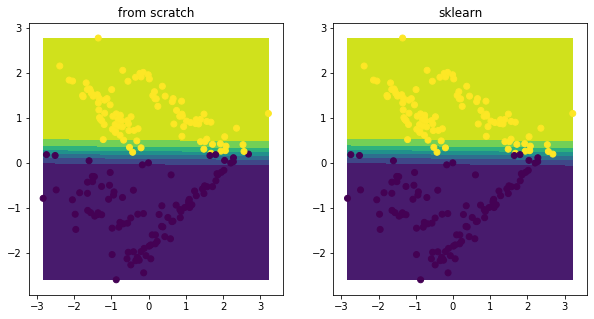

In [706]:
f, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].contourf(x1g, x2g, clf.predict(Xg).reshape(100,100))
ax[0].scatter(X[:,0], X[:,1], c=clf.predict(X).reshape(-1) > 0.5)
ax[0].set(title='from scratch')

ax[1].contourf(x1g, x2g, clf2.predict_proba(Xg)[:,1].reshape(100,100))
ax[1].scatter(X[:,0], X[:,1], c=clf2.predict(X))
ax[1].set(title='sklearn')

## Note on sklearn solution

Note that we had to switch off the penalty term. This is because to sklearn uses L2 regularization, a topic for another time. The standard solver (lbfgs) also uses a second order derivitive (similar to the Newton method) compared to the first order (sag or gradient descent) above. We see the parameters are not identical as a result. [See documentation for details](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). [See here for details on solvers](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions).